# Análise explorátoria dos dados de treino/teste

##  Importação de bibliotecas e dados

In [16]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [3]:
df = pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow')
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,Debit (Prepaid),5497590243197280,07/2022,306,YES,2,55.0,05/2008,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Credit,5175842699412235,12/2024,438,YES,1,9100.0,09/2005,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Debit,5874992802287595,05/2020,256,YES,1,14802.0,01/2006,2008,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Debit,4354185735186651,01/2020,120,YES,1,19113.0,07/2009,2014,No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,89.0,01/2008,2015,No


## Ajuste no tipo de dado

In [4]:
df['target'].value_counts()

,count
target,
No,7394705
Yes,10665


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405370 entries, 0 to 7405369
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   client_id              int64         
 3   card_id                int64         
 4   amount                 float64       
 5   use_chip               object        
 6   merchant_id            int64         
 7   merchant_city          object        
 8   merchant_state         object        
 9   zip                    float64       
 10  mcc                    object        
 11  errors                 object        
 12  description            object        
 13  target                 object        
 14  current_age            int64         
 15  retirement_age         int64         
 16  birth_year             int64         
 17  birth_month            int64         
 18  gender                

In [6]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)
df['birth_year'] = df['birth_year'].astype(str)
df['birth_month'] = df['birth_month'].astype(str)


## Análise dos dados

In [7]:
def descritiva(df_, var, vresp: str, max_classes=5):
    """
    Gera um gráfico descritivo da taxa de sobreviventes por categoria da variável especificada.

    Parâmetros:
    df : DataFrame - Base de dados a ser analisada.
    var : str - Nome da variável categórica a ser analisada.
    """

    df = df_.copy()

    if df[var].nunique()>max_classes:
        df[var] = pd.qcut(df[var], max_classes, duplicates='drop')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    sns.pointplot(data=df, y=vresp, x=var, ax=ax1)

    # Criar o segundo eixo y para a taxa de sobreviventes
    ax2 = ax1.twinx()
    sns.countplot(data=df, x=var, palette='viridis', alpha=0.5, ax=ax2)
    ax2.set_ylabel('Frequência', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax1.set_zorder(2)
    ax1.patch.set_visible(False)  # Tornar o fundo do eixo 1 transparente

    # Exibir o gráfico
    plt.show()

### Análise temporal

In [8]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['target'] = df['target']
df_time.head()

,year,year_month,target
0,2010,2010-01-01,No
1,2010,2010-01-01,No
2,2010,2010-01-01,No
3,2010,2010-01-01,No
4,2010,2010-01-01,No


In [9]:
df_time_year = pd.pivot_table(df_time, index='year', columns='target', aggfunc='count').reset_index()
df_time_year.columns = ['year', 'target_no', 'target_yes']
df_time_year['total'] = df_time_year['target_no'] + df_time_year['target_yes']
df_time_year['percent_no'] = df_time_year['target_no'] / df_time_year['total']
df_time_year['percent_yes'] = df_time_year['target_yes'] / df_time_year['total']
df_time_year

,year,target_no,target_yes,total,percent_no,percent_yes
0,2010,828956,2573,831529,0.996906,0.003094
1,2011,863391,37,863428,0.999957,0.000043
2,2012,884498,923,885421,0.998958,0.001042
3,2013,905967,1337,907304,0.998526,0.001474
4,2014,914409,664,915073,0.999274,0.000726
5,2015,928035,2189,930224,0.997647,0.002353
6,2016,930314,2448,932762,0.997376,0.002624
7,2017,937112,172,937284,0.999816,0.000184
8,2018,202023,322,202345,0.998409,0.001591


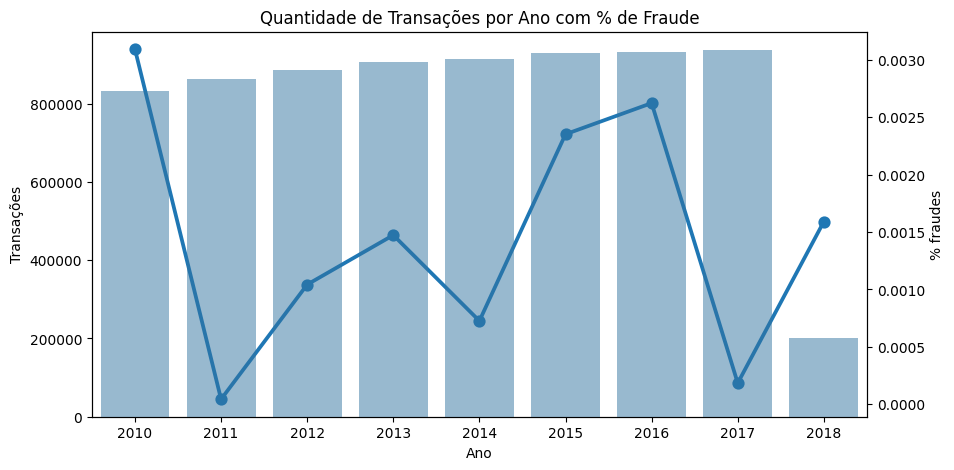

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Quantidade de Transações por Ano com % de Fraude')
sns.barplot(data=df_time_year, x='year', y='total', alpha=0.5, ax=ax1)
ax1.set_ylabel('Transações')
ax1.set_xlabel('Ano')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.pointplot(data=df_time_year, y='percent_yes', x='year', ax=ax2)

ax2.set_ylabel('% fraudes')

ax1.set_zorder(2)
ax1.patch.set_visible(False)

plt.show()

del df_time_year

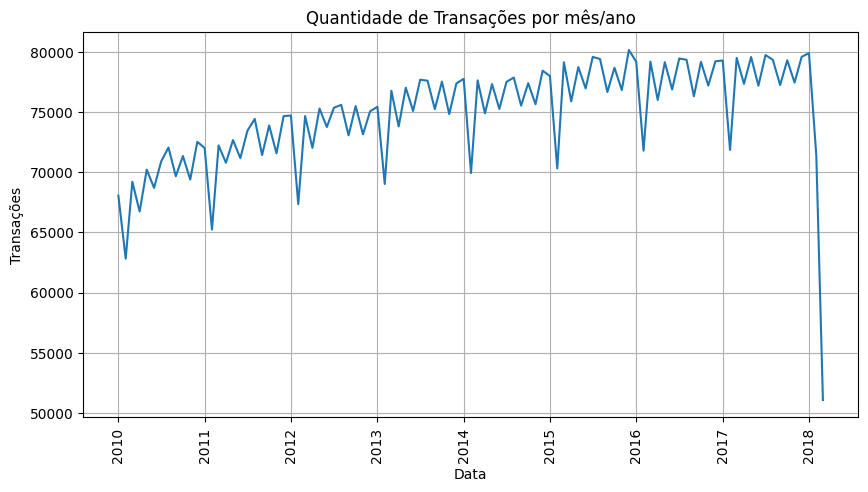

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Quantidade de Transações por mês/ano')
sns.lineplot(df_time['year_month'].value_counts().reset_index().sort_values('year_month', ascending=False).reset_index(drop=True), x='year_month', y='count', ax=ax1)
plt.xlabel('Data')
plt.ylabel('Transações')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Análise quantitativa

In [24]:
number_columns = df.select_dtypes(include=['float64', 'int64']).columns
number_columns

Index(['amount', 'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'num_cards_issued', 'credit_limit',
       'year_pin_last_changed'],
      dtype='object')

In [25]:
df[number_columns].describe()

,amount,current_age,retirement_age,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,year_pin_last_changed
count,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06,7.405370e+06
mean,4.300867e+01,5.409568e+01,6.648482e+01,3.737115e+01,-9.156545e+01,2.398496e+04,4.668939e+04,5.796217e+04,7.138754e+02,3.842856e+00,1.521537e+00,1.552508e+04,2.011252e+03
std,8.166883e+01,1.569480e+01,3.588236e+00,5.097716e+00,1.625642e+01,1.197932e+04,2.446512e+04,5.201771e+04,6.581421e+01,1.568051e+00,5.149337e-01,1.218646e+04,2.854387e+00
min,-5.000000e+02,2.300000e+01,5.300000e+01,2.130000e+01,-1.581800e+02,0.000000e+00,1.000000e+00,0.000000e+00,4.880000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.002000e+03
25%,8.940000e+00,4.200000e+01,6.500000e+01,3.389000e+01,-9.737000e+01,1.711300e+04,3.281700e+04,1.643700e+04,6.840000e+02,3.000000e+00,1.000000e+00,8.081000e+03,2.009000e+03
50%,2.903000e+01,5.200000e+01,6.600000e+01,3.835000e+01,-8.647000e+01,2.115900e+04,4.106900e+04,5.167900e+04,7.160000e+02,4.000000e+00,2.000000e+00,1.343800e+04,2.011000e+03
75%,6.384000e+01,6.300000e+01,6.800000e+01,4.112000e+01,-8.013000e+01,2.730800e+04,5.399600e+04,8.516000e+04,7.560000e+02,5.000000e+00,2.000000e+00,2.083800e+04,2.013000e+03
max,5.696780e+03,1.010000e+02,7.900000e+01,4.853000e+01,-6.867000e+01,1.631450e+05,2.801990e+05,4.618540e+05,8.500000e+02,9.000000e+00,3.000000e+00,1.413910e+05,2.020000e+03


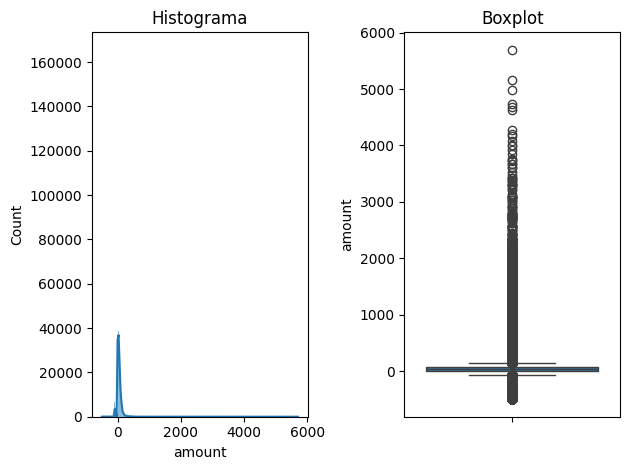

In [26]:
plt.subplot(1, 2, 1)
plt.title('Histograma')
sns.histplot(df['amount'], kde=True)

plt.subplot(1, 2, 2)
plt.title('Boxplot')
sns.boxplot(df['amount'])

plt.tight_layout()
plt.show()

In [34]:
df_adjust = pd.DataFrame()
df_adjust['amount'] = df['amount']
df_adjust['amount_log'] = np.log(df['amount'])
df_adjust['target'] = df['target']

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


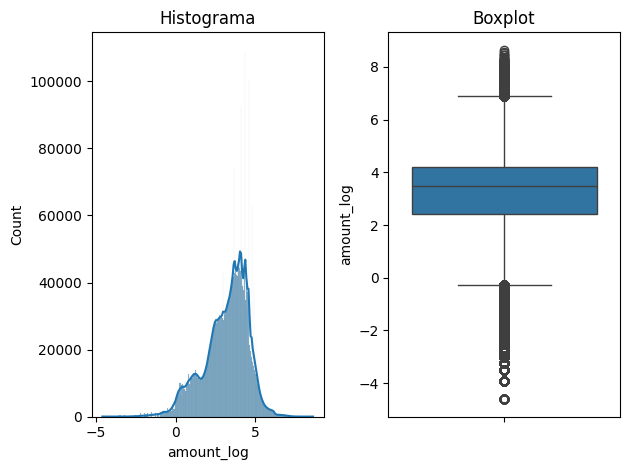

In [35]:
plt.subplot(1, 2, 1)
plt.title('Histograma')
sns.histplot(df_adjust['amount_log'], kde=True)

plt.subplot(1, 2, 2)
plt.title('Boxplot')
sns.boxplot(df_adjust['amount_log'])

plt.tight_layout()
plt.show()

In [40]:
df_adjust.query('amount_log.isna() & amount > 0')['amount']

,amount


In [41]:
df_adjust.query('amount <= 0 & target == "Yes"')

,amount,amount_log,target
15322,-339.0,NaN,Yes
28006,-104.0,NaN,Yes
50197,-437.0,NaN,Yes
64649,-450.0,NaN,Yes
72663,-138.0,NaN,Yes
...,...,...,...
7373557,-69.0,NaN,Yes
7378870,-366.0,NaN,Yes
7381558,-112.0,NaN,Yes
7381573,-180.0,NaN,Yes


In [55]:
df_adjust[(np.isfinite(df_adjust['amount_log'])) & (df_adjust['amount_log'] > 0)]

,amount,amount_log,target
1,14.57,2.678965,No
2,80.00,4.382027,No
3,46.41,3.837515,No
4,4.81,1.570697,No
5,26.46,3.275634,No
...,...,...,...
7405365,3.89,1.358409,No
7405366,120.00,4.787492,No
7405367,153.42,5.033179,No
7405368,34.80,3.549617,No


In [87]:
index = df_adjust[(np.isfinite(df_adjust['amount_log'])) & (df_adjust['amount_log'] > 0)].index

df_plot = pd.DataFrame()
df_plot['amount'] = pd.qcut(df_adjust.loc[index, 'amount_log'], 1000, duplicates='drop')
df_plot = pd.concat([df_plot, pd.get_dummies(df_adjust.loc[index, 'target'], prefix='target', dtype=int)], axis=1)
df_plot = df_plot.groupby('amount').sum().reset_index()
df_plot['resid'] =  df_plot['amount'].apply(lambda x: x.right - x.left)
df_plot

<ipython-input-87-688b7fadf3be>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_plot.groupby('amount').sum().reset_index()


,amount,target_No,target_Yes,resid
0,"(0.009850000000000001, 0.02956]",7815,15,0.01971
1,"(0.02956, 0.05827]",8694,8,0.02871
2,"(0.05827, 0.07696]",6022,2,0.01869
3,"(0.07696, 0.09531]",6239,4,0.01835
4,"(0.09531, 0.1133]",6461,2,0.01799
...,...,...,...,...
954,"(6.1069, 6.178]",6822,68,0.07110
955,"(6.178, 6.3108]",6806,86,0.13280
956,"(6.3108, 6.5423]",6803,85,0.23150
957,"(6.5423, 6.816]",6838,52,0.27370


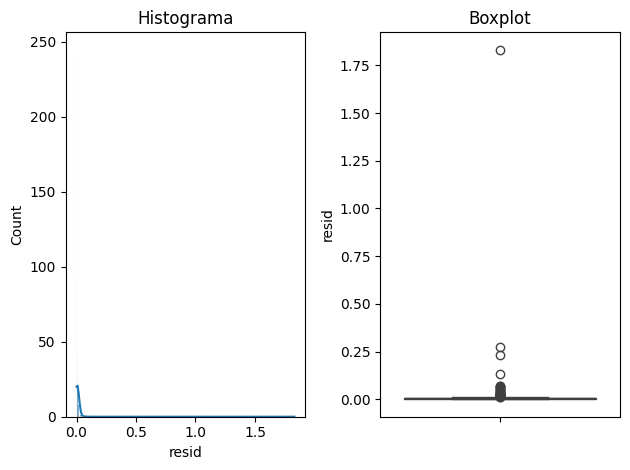

In [88]:
plt.subplot(1, 2, 1)
plt.title('Histograma')
sns.histplot(df_plot['resid'], kde=True)

plt.subplot(1, 2, 2)
plt.title('Boxplot')
sns.boxplot(df_plot['resid'])

plt.tight_layout()
plt.show()